In [10]:
import os
from collections import OrderedDict
os.chdir("../src/")

import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import torch
import torchvision
from captum.attr import visualization as viz

from models.vgg_imagenet import VGG16, VGG16_softplus
from sparse_expl_attacks import image_datasets_dir, output_dir
from sparse_expl_attacks.sparse_attack import SparseAttack
from sparse_expl_attacks.utils import (
    DifferentiableNormalize,
    convert_relu_to_softplus,
    get_expl,
    topk_intersect,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Attack params
num_iter = 1000
lr = 0.2
expl_method = "saliency"
topk = 1000
max_num_features = 1000
gamma = 1e5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load an image
np.random.seed(92)
torch.manual_seed(92)
torch.cuda.manual_seed(92)
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
normalizer = DifferentiableNormalize(mean=data_mean, std=data_std)
trasform_imagenet = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                        torchvision.transforms.CenterCrop(224),
                                        torchvision.transforms.ToTensor()])

imagenet_val = torchvision.datasets.ImageNet(root="../../image_datasets/imagenet/", 
                                             split="val", transform = trasform_imagenet)

test_loader = torch.utils.data.DataLoader(
        imagenet_val,
        batch_size=512,
        shuffle=True
    )
BATCH_SIZE = 16
indices = np.random.randint(512, size=BATCH_SIZE)
dataiter = iter(test_loader)
images_batch, labels_batch = next(dataiter)
examples = images_batch[indices][7:8].to(device)
labels = labels_batch[indices][7:8].to(device)

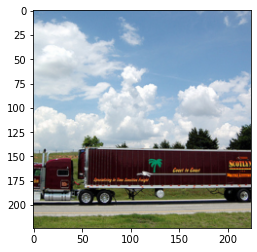

In [5]:
# Show the image
# Convert torch tensor to image
img = examples.permute(0, 2, 3, 1)
img = img.contiguous().squeeze().detach().cpu().numpy()
img = np.clip(img, 0, 1)
plt.imshow(img)

In [6]:
model = torchvision.models.vgg16(pretrained=True)
model = convert_relu_to_softplus(model, beta=10)
model = model.eval().to(device)
# ReLu model
model_relu = torchvision.models.vgg16(pretrained=True)
model_relu = model_relu.eval().to(device)

In [7]:
# Perform the attack.
sparse_attack = SparseAttack(
    model=model,
    model_relu=model_relu,
    expl_method=expl_method,
    num_iter=num_iter,
    lr=lr,
    topk=topk,
    max_num_features=max_num_features,
    gamma=gamma,
    normalizer=normalizer,
)

In [8]:
x_adv_single_step = sparse_attack.attack(
    attack_type="single_step", x_input=examples, y_input=labels
)

x_adv_pgd0 = sparse_attack.attack(
    attack_type="pgd0", x_input=examples, y_input=labels
)

x_adv_greedy = sparse_attack.attack(
    attack_type="greedy", x_input=examples, y_input=labels
)


In [9]:
# Compute the explanations!
org_expl = get_expl(
    model, 
    normalizer.forward(examples), 
    expl_method, 
    device,
    labels, 
    normalize=False)

adv_expl_single_step = get_expl(
    model, 
    normalizer.forward(x_adv_single_step), 
    expl_method, 
    device,
    labels, 
    normalize=False)

adv_expl_pgd0 = get_expl(
    model, 
    normalizer.forward(x_adv_pgd0), 
    expl_method, 
    device,
    labels, 
    normalize=False)

adv_expl_greedy = get_expl(
    model, 
    normalizer.forward(x_adv_greedy), 
    expl_method, 
    device,
    labels, 
    normalize=False)


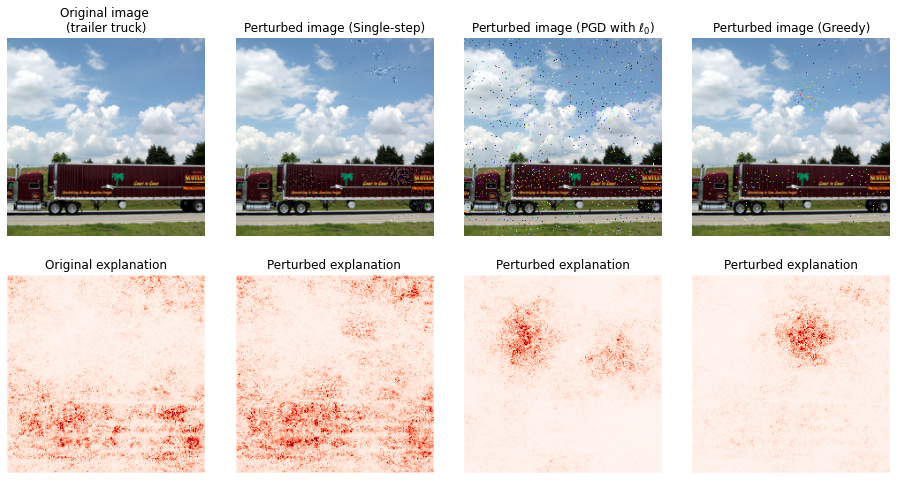

In [11]:
fig, ax = plt.subplots(2,4, figsize=(16, 8))
ax[0,0].imshow(examples.squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,0].set_title("Original image \n(trailer truck)", fontsize=12)
ax[0,0].axis("off")
viz.visualize_image_attr(
    np.transpose(org_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(examples.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,0]), use_pyplot=False)
ax[1,0].axis("off")
ax[1,0].set_title("Original explanation", fontsize=12)

ax[0,1].imshow(x_adv_single_step.squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,1].axis("off")
ax[0,1].set_title("Perturbed image (Single-step)", fontsize=12)
viz.visualize_image_attr(
    np.transpose(adv_expl_single_step.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_adv_single_step.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,1]), use_pyplot=False)
ax[1,1].axis("off")
ax[1,1].set_title("Perturbed explanation", fontsize=12)

ax[0,2].imshow(x_adv_pgd0.squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,2].axis("off")
ax[0,2].set_title("Perturbed image (PGD with $\ell_0$)", fontsize=12)
viz.visualize_image_attr(
    np.transpose(adv_expl_pgd0.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_adv_pgd0.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,2]), use_pyplot=False)
ax[1,2].axis("off")
ax[1,2].set_title("Perturbed explanation", fontsize=12)

ax[0,3].imshow(x_adv_greedy.squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,3].axis("off")
ax[0,3].set_title("Perturbed image (Greedy)", fontsize=12)
viz.visualize_image_attr(
    np.transpose(adv_expl_greedy.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_adv_greedy.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,3]), use_pyplot=False)
ax[1,3].axis("off")
ax[1,3].set_title("Perturbed explanation", fontsize=12)

plt.subplots_adjust(wspace=0.1);